In [1]:
import numpy as np
from scipy import optimize
import pandas as pd
import pickle as pk
import tifffile
import matplotlib.pyplot as plt
from scipy import interpolate
import glob,os

In [2]:
cd ~/PycharmProjects/IMyG_2/

/Users/jz-rolling/PycharmProjects/IMyG_2


In [3]:
import IMyG as im

In [4]:
def moving_window_average(data,window_size = 5):
    if len(data) <= window_size+2:
        raise ValueError("Input array does not have enough values")
    else:
        cum_sum = np.cumsum(np.insert(data,0,0))
        return ((cum_sum[window_size:]-cum_sum[:-window_size])/float(window_size))

def measure_variability(data,cut_off = 10,percentile = 90):
    val = np.log10(data[data >= np.percentile(data,percentile)].mean()/data.mean())
    if val > 1:
        val = 1
    return round(val,3)

def center_of_mass(data,xcor):
    center = np.sum((data)*xcor)/np.sum((data))
    return np.round(center,3)

def normalize_array(data,min_val,max_val,base=0):
    return((data-min_val+base)/(max_val-min_val+base))

def weighted_segmentation(data,quantile_filter = 0.05,weighted_center = True):
    if quantile_filter:
        min_threshould = np.quantile(data,quantile_filter)
    else:
        min_threshould = 0
    filtered_data = data.copy()
    normalized_data = normalize_array(filtered_data,min_threshould,filtered_data.max())
    normalized_data[filtered_data<=min_threshould] = 0.0
    xcor = np.linspace(0,1,len(normalized_data))
    if weighted_center:
        com_0 = center_of_mass(normalized_data,xcor)
    else:
        com_0 = 0.5
    adjusted_center_dist_1 = int(com_0*len(normalized_data))
    adjusted_center_dist_2 = len(normalized_data) - adjusted_center_dist_1
    first_half = normalized_data[:adjusted_center_dist_1]
    xcor_first = xcor[:adjusted_center_dist_1]
    second_half = normalized_data[-adjusted_center_dist_2:]
    xcor_second = xcor[-adjusted_center_dist_2:]
    com_1 = center_of_mass(first_half,xcor_first)
    com_2 = center_of_mass(second_half,xcor_second)
    com_dist = com_2-com_1
    return [com_1,com_0,com_2],round(com_dist,3)

def segmented_mean(data,quantile_filter = 0.05,weighted_center = True):
    smoothed = moving_window_average(data)
    interpolated = np.interp(np.linspace(0,1,200),np.linspace(0,1,len(data)),data)
    smoothed = moving_window_average(interpolated)
    [c1,c2,c3],c_dist = weighted_segmentation(smoothed,\
                                              quantile_filter=quantile_filter,\
                                              weighted_center=weighted_center)
    n_points = len(smoothed)
    c1,c2,c3 = int(c1*n_points),int(c2*n_points),int(c3*n_points)
    l1,l2,r1,r2 = smoothed[:c1].mean(),smoothed[c1:c2].mean(),smoothed[c2:c3].mean(),smoothed[c3:].mean()
    h1,h2 = smoothed[:c2].mean(),smoothed[c2:].mean()
    pole,center = np.concatenate([smoothed[:c1],smoothed[c3:]]).mean(),\
                  smoothed[c1:c3].mean()
    return(l1,l2,r1,r2,h1,h2,pole,center)

def measure_symmetry(p1,p2):
    if p1>p2:
        return round(p2/p1,3)
    else:
        return round(p1/p2,3)

def measure_centrifugality(pole,center):
    return(round(np.log2(pole/center),3))

def measure_membrane_idx(data,quantile_filter = 0.2,weighted_center = True,window = 2):
    interpolated = np.interp(np.linspace(0,1,100),np.linspace(0,1,len(data)),data)
    smoothed = moving_window_average(interpolated)
    [c1,c2,c3],c_dist = weighted_segmentation(smoothed,\
                                              quantile_filter=quantile_filter,\
                                              weighted_center=weighted_center)
    n_points = len(smoothed)
    w = window
    c1,c2,c3 = int(c1*n_points),int(c2*n_points),int(c3*n_points)
    #print(c1,c2,c3)
    v1 = smoothed[max(0,c1-window):min(len(smoothed),c1+window)].mean()
    v2 = smoothed[max(0,c2-window):min(len(smoothed),c2+window)].mean()
    v3 = smoothed[max(0,c3-window):min(len(smoothed),c3+window)].mean()
    ratio = round(np.average([v1,v3])/v2,3)
    return ratio,c_dist

In [6]:
def batch_measure(output_path):
    folders = glob.glob(output_path+"Well*/")
    for folder in folders:
        well_info = folder.split("/")[-2]
        files = glob.glob(folder+"*.pk")
        pooled_data = []
        output = []
        for file in files:
            pooled_data += pk.load(open(file,'rb'))
        counter = 0
        for cell in pooled_data:
            try:
                fl_straighten_axial = cell.fl_straighten["FITC"][2]
                fl_straighten_lateral = cell.fl_straighten["FITC"][0]
                fl_contour = cell.measure_along_contour["FITC"]
                _r,membrane_idx = measure_membrane_idx(fl_straighten_lateral)
                l1,l2,r1,r2,h1,h2,pole,center = segmented_mean(fl_straighten_axial)
                centrifugality = measure_centrifugality(pole,center)
                variability_axial = measure_variability(fl_straighten_axial)
                variability_contour = measure_variability(fl_contour)
                body_symmetry = measure_symmetry(h1,h2)
                pole_symmetry = measure_symmetry(l1,r2)
                data = [counter,cell.plate_idx,cell.colony_label,cell.cell_label,cell.curvature,\
                        round(cell.length,2),round(cell.width.mean()*cell.pixel_microns,2),round(cell.perimeter_precise,2),\
                        cell.mean_fl_intensity["FITC"],cell.SNR["FITC"],\
                        membrane_idx,centrifugality,variability_axial,variability_contour,body_symmetry,pole_symmetry]
                counter += 1
                output.append(data)
            except:
                print("Error found!")
        column_name = ["Index","Image","Colony","Cell","Curvature","Length [um]","Mean width [um]","Perimeter [um]",\
                       "Mean fluorescent intensity","SNR","Membrane index","Centrifugality","Variability","Variability on membrane",\
                       "Body symmetry","Pole symmetry"]
        df = pd.DataFrame(output,columns=column_name)
        df.to_excel(output_path+well_info+"summary.xls")

In [7]:
root_folder = "/Volumes/Sam/"
MSR_folders = glob.glob(root_folder+"MSR*_IDW/")
#pattern = re.compile("(MSR[0-9]{1,2})")

for i in [13]:
    folder = root_folder+"MSR{}_IDW/".format(i)
    name = folder.split("/")[-2]
    plate = "MSR{}".format(i)
    subfolders = glob.glob(folder+"*raw_files/")
    if len(subfolders) == 1:
        print("Processing plate %s"%(plate))
        if len(glob.glob(subfolders[0]+"*raw_files/"))!=0:
            for babyfolder in glob.glob(subfolders[0]+"*raw_files/"):
                batch_measure(babyfolder+"output/")
        else:
            batch_measure(subfolders[0]+"output/")

"""        
folder = root_folder+"MSR_PP1_IDW/"
name = folder.split("/")[-2]
plate = "MSR_PP1"
subfolders = glob.glob(folder+"*raw_files/")
if len(subfolders) == 1:
    print("Processing plate %s"%(plate))
    if len(glob.glob(subfolders[0]+"*raw_files/"))!=0:
        for babyfolder in glob.glob(subfolders[0]+"*raw_files/"):
            batch_measure(babyfolder+"output/")
    else:
        batch_measure(subfolders[0]+"output/")
"""   

Processing plate MSR13
Error found!
Error found!
Error found!
Error found!
Error found!
Error found!


'        \nfolder = root_folder+"MSR_PP1_IDW/"\nname = folder.split("/")[-2]\nplate = "MSR_PP1"\nsubfolders = glob.glob(folder+"*raw_files/")\nif len(subfolders) == 1:\n    print("Processing plate %s"%(plate))\n    if len(glob.glob(subfolders[0]+"*raw_files/"))!=0:\n        for babyfolder in glob.glob(subfolders[0]+"*raw_files/"):\n            batch_measure(babyfolder+"output/")\n    else:\n        batch_measure(subfolders[0]+"output/")\n'

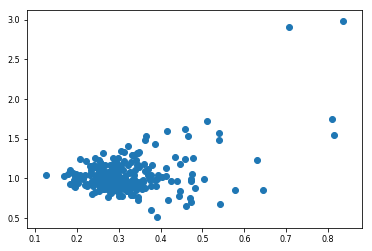

In [222]:
plt.scatter(cv_list,outlist2)
#plt.plot([2,12],[1,1],'r')

In [390]:
data1[17].measure_along_contour

{'FITC': array([ 33.17,  32.29,  24.36,  40.94,  32.59,  47.32,  34.7 ,  29.97,
         66.44,  51.54,  15.55,  49.77,  47.82,  94.88,  63.96,  72.18,
         45.2 ,  19.28,  57.84,  75.57,  32.11,   6.42,  76.57,  48.06,
         26.87,   5.67,   2.57,  35.42,  68.97,  91.72,  37.68,  35.53,
         42.62,  61.68,  24.9 ,  24.62,  40.18,  48.67,  30.07,  30.  ,
         11.85,  14.54,  35.34,  16.45,  11.38,  16.18,  41.12,  58.39,
         51.82,  61.84,  17.74,   8.36,  37.76,  74.7 ,  68.14,  60.77,
         70.89,  79.07,  79.3 ,  54.75,  48.78,  23.54,  23.18,  37.7 ,
         33.99,  47.94,  42.69,  54.93,  32.07,  25.22,  44.01,  71.57,
         87.02,  58.35,  60.42,  57.43,  17.49,  33.83,  41.69,  59.82,
         49.5 ,  48.24,  48.92,  18.88,  27.2 ,  59.32,  52.22,  28.5 ,
         42.62,  57.54,  19.52,  31.86,  23.48,  56.66,  39.4 ,  55.76,
         82.63,  25.58,  40.25,  29.98,  30.86,  42.36,  51.65,  91.16,
        111.55,  66.86,  55.01, 101.64, 103.18,  86.37, 

In [657]:
len(data2)

459

In [643]:
SNR = []
for cell in data2:
    if cell.SNR["FITC"] >3:
        SNR.append(cell.SNR["FITC"])

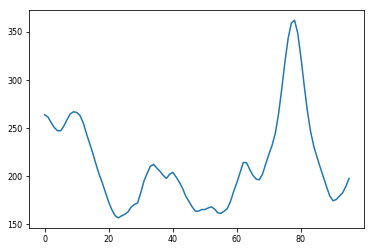

In [91]:
y = data1[54].fl_straighten["FITC"][2]
x = np.linspace(0,1,len(y))
z_interpolated = interpolate.interp1d(x,y)
m = z_interpolated(np.linspace(0,1,100))
m_smoothed = moving_window_average(m)
plt.plot(m_smoothed)

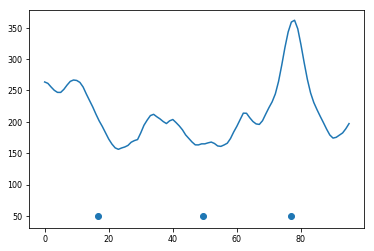

In [92]:
[a,b,c],d = adjusted_centrifugality(m_smoothed,quantile_filter=0.02)
plt.plot(m_smoothed)
plt.scatter([a*len(m_smoothed),b*len(m_smoothed),c*len(m_smoothed)],[50,50,50])

In [93]:
a,b,c = int(a*len(m_smoothed)),int(b*len(m_smoothed)),int(c*len(m_smoothed))

In [94]:
m_smoothed[:a].mean(),m_smoothed[a:b].mean(),m_smoothed[b:c].mean(),m_smoothed[c:].mean()

(253.27168484848482, 184.08128007346184, 201.79450729517376, 243.2351490909091)

In [96]:
(253.27168484848482/184.08128007346184)+(243.2351490909091/201.79450729517376)

2.5812293759384417

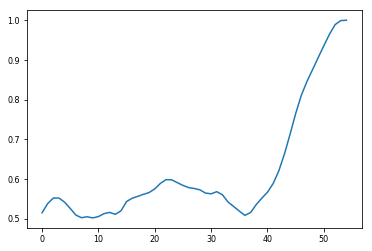

In [224]:
plt.plot(n_array[n_array>0.5])

In [261]:
m_smoothed = m_smoothed[:-1]
m_copied = np.zeros(m_smoothed.shape)
w = 40
for i in range(len(m_smoothed)):
    m_copied[max(0,i-w):min(len(m_smoothed),i+w)] = m_smoothed[max(0,i-w):min(len(m_smoothed),i+w)].min()
m_copied[i:] = m_copied[i]

In [248]:
n_array = normalize_array(m_smoothed,m_smoothed.min(),m_smoothed.max(),base=0)

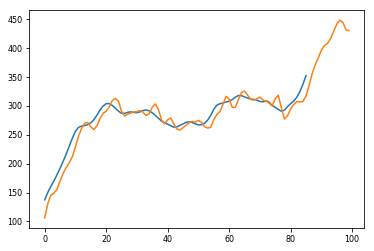

In [284]:
plt.plot(m_smoothed)
plt.plot(m)

In [272]:
m_smoothed[m_smoothed>np.percentile(m_smoothed,90)].mean()/m_smoothed.mean()

1.1559287731440526

In [271]:
m_smoothed.max()/m_smoothed.min()

2.5625712776618665

In [273]:
from math import log

In [283]:
np.log10(2)

0.3010299956639812

In [299]:
a = moving_window_average(m,window_size=5)
b = np.flip(moving_window_average(np.flip(m),window_size=5))

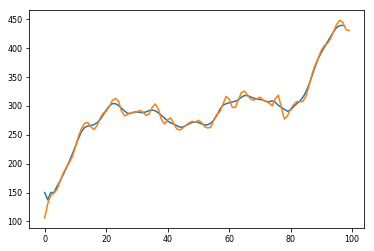

In [322]:
plt.plot(np.insert(a,[0,1],150))
plt.plot(m)

In [2]:
import umap

In [579]:
data1 = pd.read_excel("/Volumes/Sam/MSR8_IDW/plate8_raw_files/07252019_raw_files/output/Well_B12summary.xls")
data2 = pd.read_excel("/Volumes/Sam/MSR8_IDW/plate8_raw_files/07252019_raw_files/output/Well_D07summary.xls")

In [580]:
data1["Well"] = ["D06"]*len(data1)
data2["Well"] = ["F12"]*len(data2)

In [581]:
merged = pd.concat([data1,data2])
filtered = merged[merged["SNR"]>2]

In [54]:
features = ["Membrane index","Centrifugality","Variability","Variability on membrane"]

In [14]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [15]:
x = input_data.values
y = df["Well"].values

In [75]:
x_standardized = preprocessing.StandardScaler().fit_transform(x)
#x_standardized = x.copy()
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_standardized)
principalDf = pd.DataFrame(data = principalComponents,columns = ['PC1','PC2'])

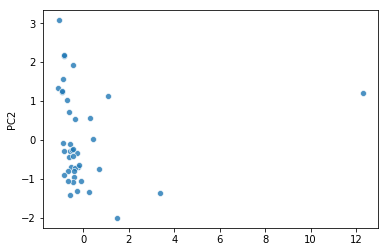

In [77]:
import seaborn as sns
sns.scatterplot(principalDf["PC1"].values,principalDf["PC2"],alpha = 0.8)

(array([  3.,   8.,  21.,  31.,  41.,  71., 112., 181., 312., 357., 413.,
        319., 203.,  99.,  71.,  42.,  32.,  22.,   9.,  12.,  12.,  19.,
         10.,  15.,  11.,   7.,   6.,  10.,   5.,   7.,   3.,   6.,   2.,
          3.,   2.,   1.,   4.,   1.,   2.,   3.]),
 array([0.199 , 0.2126, 0.2262, 0.2398, 0.2534, 0.267 , 0.2806, 0.2942,
        0.3078, 0.3214, 0.335 , 0.3486, 0.3622, 0.3758, 0.3894, 0.403 ,
        0.4166, 0.4302, 0.4438, 0.4574, 0.471 , 0.4846, 0.4982, 0.5118,
        0.5254, 0.539 , 0.5526, 0.5662, 0.5798, 0.5934, 0.607 , 0.6206,
        0.6342, 0.6478, 0.6614, 0.675 , 0.6886, 0.7022, 0.7158, 0.7294,
        0.743 ]),
 <a list of 40 Patch objects>)

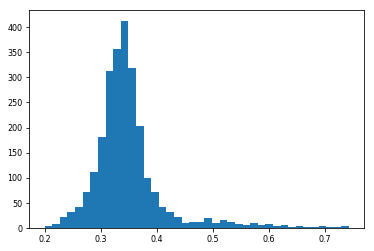

In [605]:
plt.hist(data1["Membrane index"],bins = 40)

In [76]:
pca.explained_variance_ratio_

array([0.62961116, 0.19403802])

In [606]:
print(pca.singular_values_)  

[94.92667426 64.1646697 ]


In [5]:
xls = glob.glob("/Users/jz-rolling/Desktop/summary_sheets/*.xls")

In [6]:
import re
pattern = re.compile("Well_([A-Z][0-9]+)summary.xls")
out = []
wells = []
feature = ["Mean width [um]","Mean fluorescent intensity",\
           "SNR","Length [um]","Membrane index","Centrifugality",\
           "Variability","Variability on membrane","Body symmetry","Pole symmetry"]
for file in xls:
    plate = re.search(pattern,file).group(1)
    data = pd.read_excel(file).loc[:,feature].copy()
    filtered = data[data["SNR"]>3]
    if len(filtered) >= 50:
        mean_val = filtered.describe().iloc[1]
        mean_val["Well"] = plate
        mean_val["Count"] = len(filtered)
        out.append(list(mean_val.values))

In [7]:
df = pd.DataFrame(out,columns=feature+["Well","Count"])

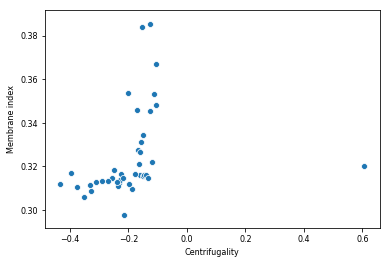

In [649]:
sns.scatterplot(df["Centrifugality"],df["Membrane index"])

In [27]:
u = umap.UMAP()

In [66]:
m = u.fit_transform(df[features])

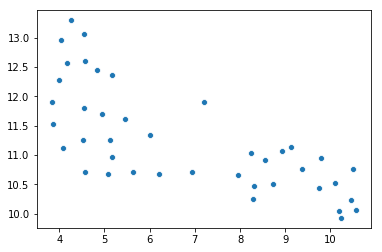

In [69]:
sns.scatterplot(m[:,0],m[:,1])

In [68]:
m

array([[10.495869 , 10.761607 ],
       [ 8.285487 , 10.254507 ],
       [ 9.757578 , 10.437706 ],
       [ 4.1786385, 12.5726595],
       [ 9.120269 , 11.141239 ],
       [ 4.569837 , 10.710091 ],
       [ 5.1619806, 10.975656 ],
       [ 4.523098 , 11.259278 ],
       [ 4.0720863, 11.12001  ],
       [ 4.543413 , 11.8007   ],
       [ 3.8673816, 11.534502 ],
       [ 6.203919 , 10.686604 ],
       [10.179835 , 10.049163 ],
       [ 5.464338 , 11.619508 ],
       [ 6.015774 , 11.344526 ],
       [ 4.956838 , 11.691537 ],
       [ 8.559876 , 10.918237 ],
       [ 8.919589 , 11.071637 ],
       [ 4.8315263, 12.455841 ],
       [ 4.25285  , 13.294627 ],
       [ 9.802041 , 10.94473  ],
       [ 5.1680765, 12.367624 ],
       [ 4.0397725, 12.967509 ],
       [ 9.3636675, 10.768802 ],
       [ 5.0779715, 10.681438 ],
       [ 5.625557 , 10.707243 ],
       [ 8.24084  , 11.029231 ],
       [ 8.319391 , 10.469724 ],
       [10.568784 , 10.062906 ],
       [ 5.128389 , 11.262048 ],
       [10